In [1]:
# Imported Libraries
import numpy as np
import pandas as pd 
import copy
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

#Sampling Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Visual Libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Performance metrics libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

# Tensorflow
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse
from keras import backend as K
from keras.optimizers import Adam

from VAE import VAE_oversampling
from GAN import GAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
tf.random.set_seed(42)
random.seed(seed)

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Train, Validate, Test split

In [4]:
X = df.drop(['Class'], axis=1)
y = df['Class']

#Split data initially to train and remainingfor cross
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, stratify=y)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the validation dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
print(f"The validation and test datasets have {sorted(Counter(y_test).items())[0][1]} records for the majority class and {sorted(Counter(y_test).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 227845
The number of records in the validation dataset is 56962
The training dataset has 227451 records for the majority class and 394 records for the minority class.
The validation and test datasets have 56864 records for the majority class and 98 records for the minority class.


In [5]:
def model_scores(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 score:", f1_score(y_true, y_pred))
    print("ROC_AUC:", roc_auc_score(y_true, y_pred))

## Data Augmentation with VAE

### Hyperparameter Tuning with cross validation

############################### Parameters tested: {'max_depth': None, 'n_estimators': 50} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 107s 367ms/step - loss: 34.3037 - val_loss: 28.3303
Epoch 2/100
284/284 [==============================] - 104s 367ms/step - loss: 29.6595 - val_loss: 25.9898
Epoch 3/100
284/284 [==============================] - 104s 368ms/step - loss: 28.5668 - val_loss: 26.2786
Epoch 4/100
284/284 [==============================] - 22s 77ms/step - loss: 28.3222 - val_loss: 25.4520
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 28.0240 - val_loss: 25.3987
Epoch 6/100
284/284 [=====================

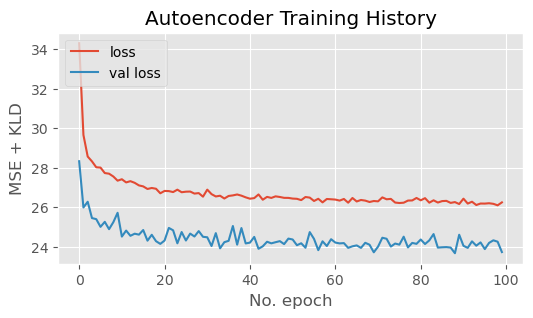

5677/5677 [==============================] - 279s 49ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 106s 369ms/step - loss: 35.2702 - val_loss: 29.0171
Epoch 2/100
283/283 [==============================] - 105s 370ms/step - loss: 30.5556 - val_loss: 25.8012
Epoch 3/100
283/283 [==============================] - 73s 257ms/step - loss: 28.7373 - val_loss: 25.3464
Epoch 4/100
283/283 [==============================] - 61s 216ms/step - loss: 28.2460 - val_loss: 24.9633
Epoch 5/100
283/283 [==============================] - 37s 131ms/step - loss: 28.3019 - val_loss: 25.0949
Epoch 6/100
283/283 [==============================] - 24s 85ms/step - loss: 27.9697 - val_loss: 24.924

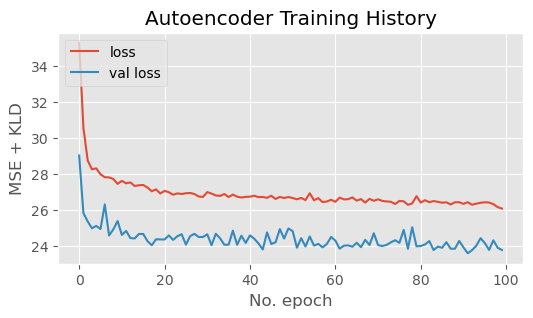

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 34.4010 - val_loss: 27.2977
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.8799 - val_loss: 25.0249
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4367 - val_loss: 24.5742
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2614 - val_loss: 24.4632
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.3323 - val_loss: 24.5896
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0580 - val_loss: 24.1715
Epoch 7/100
283/283

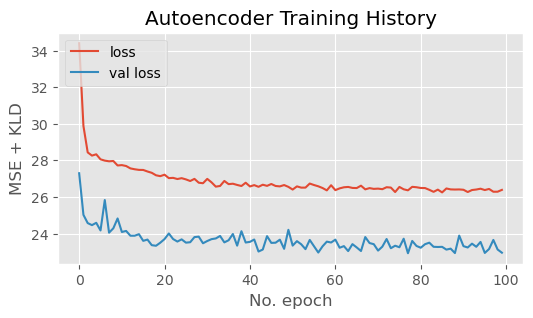

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.1304 - val_loss: 29.9839
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9282 - val_loss: 26.5732
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4824 - val_loss: 25.9608
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4431 - val_loss: 25.9654
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7701 - val_loss: 25.8064
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8080 - val_loss: 25.5380
Epoch 7/100
283/283

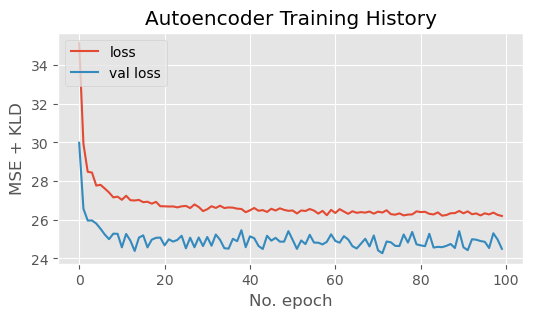

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 101s 352ms/step - loss: 34.8786 - val_loss: 39.9832
Epoch 2/100
283/283 [==============================] - 99s 349ms/step - loss: 29.9199 - val_loss: 37.0819
Epoch 3/100
283/283 [==============================] - 99s 351ms/step - loss: 27.5623 - val_loss: 36.0579
Epoch 4/100
283/283 [==============================] - 102s 360ms/step - loss: 27.0022 - val_loss: 35.8474
Epoch 5/100
283/283 [==============================] - 101s 355ms/step - loss: 26.6980 - val_loss: 35.7176
Epoch 6/100
283/283 [==============================] - 99s 350ms/step - loss: 26.7781 - val_loss: 35.840

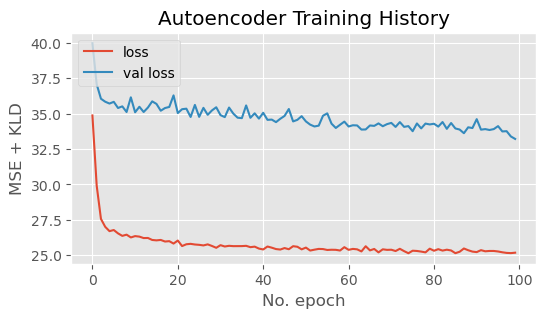

5677/5677 [==============================] - 13s 2ms/step
############################### Parameters tested: {'max_depth': None, 'n_estimators': 100} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 34.5923 - val_loss: 29.5214
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8610 - val_loss: 25.6623
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4910 - val_loss: 26.3104
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.1998 - val_loss: 25.3908
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8115 - val_loss: 25.14

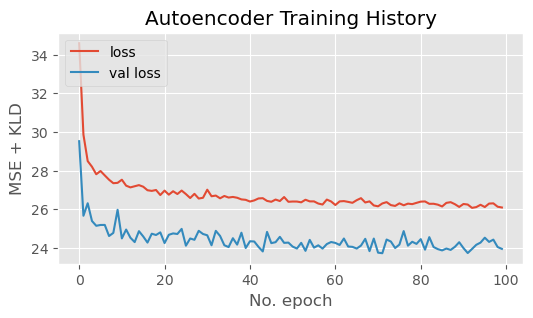

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.5871 - val_loss: 28.0321
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0471 - val_loss: 26.3741
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.7470 - val_loss: 25.2666
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2992 - val_loss: 24.9697
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4534 - val_loss: 24.9497
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0829 - val_loss: 24.5509
Epoch 7/100
283/283

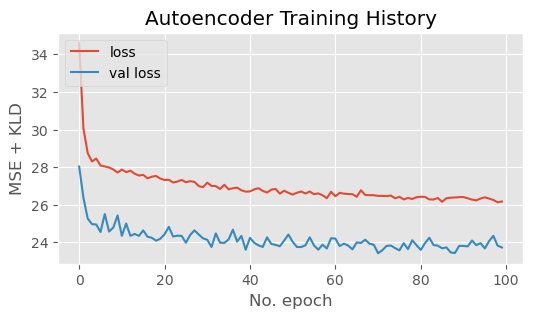

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.1207 - val_loss: 29.1921
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.5622 - val_loss: 25.6670
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6013 - val_loss: 24.5236
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5100 - val_loss: 24.5995
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0656 - val_loss: 24.2769
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8740 - val_loss: 24.2071
Epoch 7/100
283/283

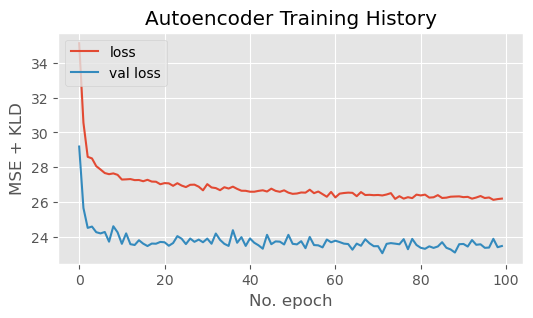

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 7ms/step - loss: 35.1811 - val_loss: 30.5049
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.9395 - val_loss: 27.8797
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.9420 - val_loss: 26.1848
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2968 - val_loss: 26.1629
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8246 - val_loss: 25.7959
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8932 - val_loss: 25.8203
Epoch 7/100
283/283

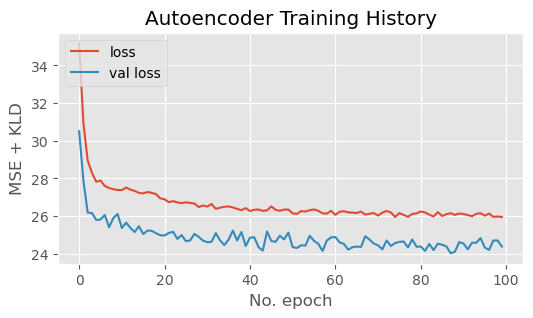

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.0058 - val_loss: 40.6051
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.0498 - val_loss: 37.0854
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0934 - val_loss: 36.1809
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.2505 - val_loss: 36.3962
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.1156 - val_loss: 35.6374
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.7471 - val_loss: 36.3601
Epoch 7/100
283/283

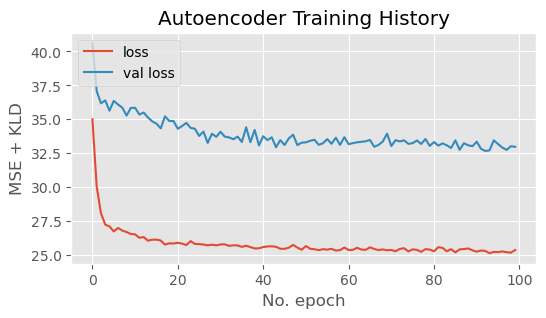

5677/5677 [==============================] - 11s 2ms/step
############################### Parameters tested: {'max_depth': 5, 'n_estimators': 50} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 34.8783 - val_loss: 29.0844
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.7583 - val_loss: 26.3748
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5860 - val_loss: 25.7073
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.1112 - val_loss: 25.2357
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.9410 - val_loss: 25.3850
E

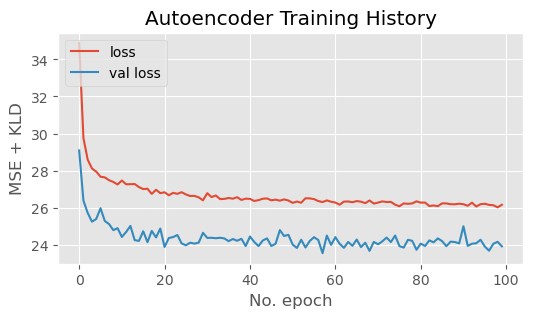

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 34.3464 - val_loss: 28.4646
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9445 - val_loss: 25.7123
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4230 - val_loss: 25.5596
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0908 - val_loss: 24.9361
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.1205 - val_loss: 25.0358
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8275 - val_loss: 25.1028
Epoch 7/100
283/283

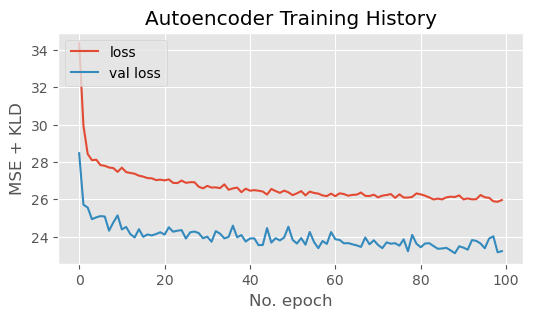

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.3472 - val_loss: 29.1184
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.4491 - val_loss: 25.4592
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.8065 - val_loss: 24.7409
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.9043 - val_loss: 24.6474
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1280 - val_loss: 24.3525
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1310 - val_loss: 24.0654
Epoch 7/100
283/283

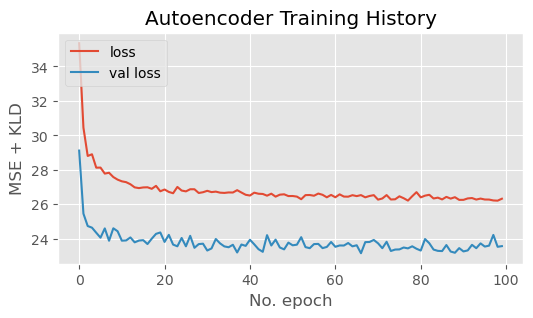

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.1000 - val_loss: 29.6391
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.8336 - val_loss: 26.4951
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2726 - val_loss: 26.0949
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0843 - val_loss: 26.1120
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7440 - val_loss: 25.7782
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7765 - val_loss: 25.5248
Epoch 7/100
283/283

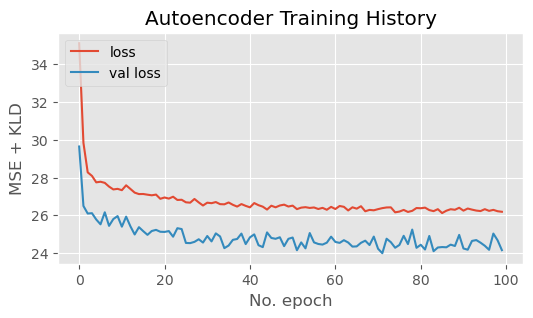

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 33.9325 - val_loss: 38.6744
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6890 - val_loss: 36.1677
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.2083 - val_loss: 36.0140
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 26.8406 - val_loss: 36.3640
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5864 - val_loss: 35.8492
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.5594 - val_loss: 35.6732
Epoch 7/100
283/283

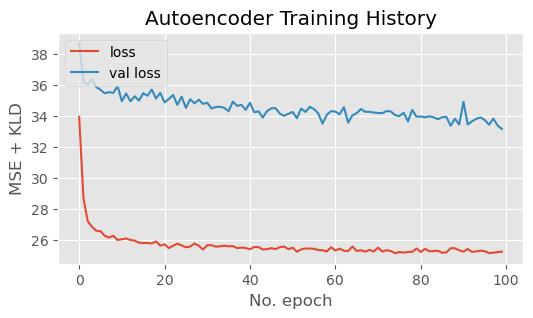

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'max_depth': 5, 'n_estimators': 100} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 35.3335 - val_loss: 30.0564
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.3014 - val_loss: 26.1283
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.7566 - val_loss: 26.4101
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.3989 - val_loss: 25.8737
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.9906 - val_loss: 25.3023


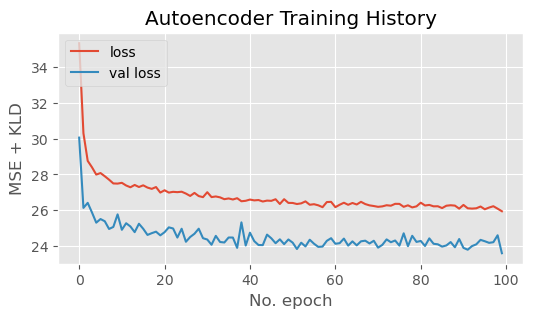

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 34.7131 - val_loss: 28.9619
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.0708 - val_loss: 25.3736
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5825 - val_loss: 24.8458
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2705 - val_loss: 24.9043
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0128 - val_loss: 24.3158
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8956 - val_loss: 24.9004
Epoch 7/100
283/283

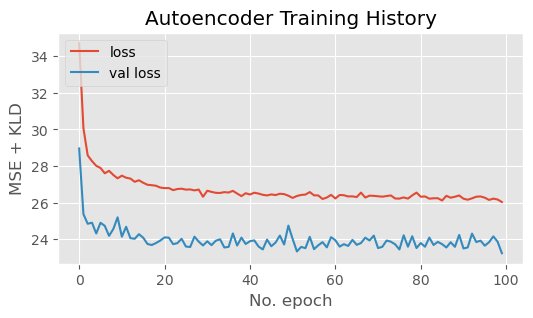

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 34.9453 - val_loss: 28.2109
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0713 - val_loss: 25.3314
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4291 - val_loss: 24.7569
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.1856 - val_loss: 24.3442
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1947 - val_loss: 24.0290
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7728 - val_loss: 24.1315
Epoch 7/100
283/283

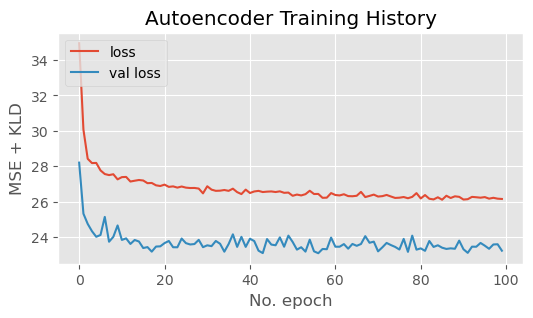

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.3007 - val_loss: 29.5316
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8743 - val_loss: 26.4169
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4835 - val_loss: 25.9667
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3759 - val_loss: 26.1694
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8496 - val_loss: 25.6321
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9355 - val_loss: 25.8489
Epoch 7/100
283/283

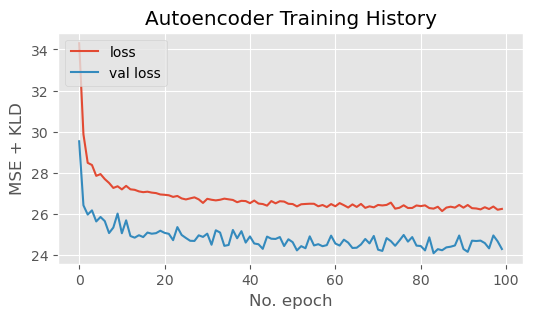

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 33.6413 - val_loss: 38.5976
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 28.8633 - val_loss: 35.8503
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.5343 - val_loss: 35.9811
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 26.9732 - val_loss: 36.0916
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 26.8610 - val_loss: 35.5489
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.6334 - val_loss: 36.0537
Epoch 7/100
283/283

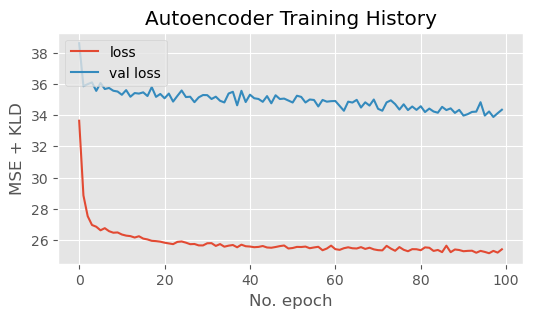

5677/5677 [==============================] - 10s 2ms/step
Accuracy:, 0.999513 (+/- 0.000035)
Precision: 0.944588 (+/- 0.022510)
Recall: 0.763875 (+/- 0.026882)
F1 score: 0.844098 (+/- 0.013249)
ROC_AUC: 0.881898 (+/- 0.013430)
Best hyperparameters: {'max_depth': None, 'n_estimators': 100}


In [24]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100], 
    'max_depth': [None, 5],
}

# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        # Variational Oversampling 
        vos = VAE_oversampling(hidden_dim= 64,
                                latent_dim=2,
                                original_dim=30,
                                minority_class_id=1,
                                epochs=100,
                                batch_size=1,
                                num_samples_to_generate = num_samples,
                                random_state = 0,
                                optimizer="adam")
        
  

        #Fit the VAE oversampling model and get new data set
        X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
        
        std = StandardScaler()

        X_train_processed = std.fit_transform(X_res_val) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params

# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.3037 - val_loss: 28.3303
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.6595 - val_loss: 25.9898
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5668 - val_loss: 26.2786
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.3222 - val_loss: 25.4520
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0240 - val_loss: 25.3987
Epoch 6/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0079 - val_loss: 25.0089
Epoch 7/100
284/284 [==============================] - 1s 3ms/step - loss: 27

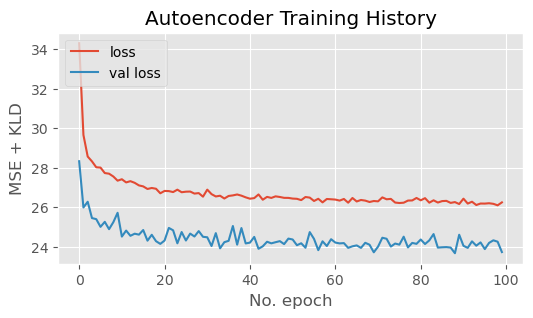

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.2702 - val_loss: 29.0171
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.5556 - val_loss: 25.8012
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.7373 - val_loss: 25.3464
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2460 - val_loss: 24.9633
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3019 - val_loss: 25.0949
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9697 - val_loss: 24.9241
Epoch 7/100
283/283

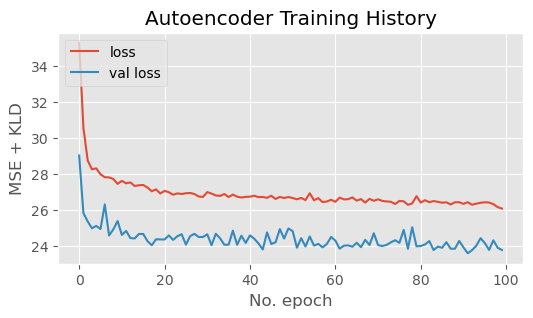

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4010 - val_loss: 27.2977
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8799 - val_loss: 25.0249
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4367 - val_loss: 24.5742
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2614 - val_loss: 24.4632
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3323 - val_loss: 24.5896
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0580 - val_loss: 24.1715
Epoch 7/100
283/283

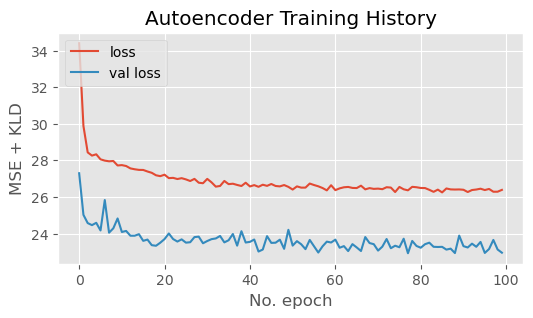

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.1304 - val_loss: 29.9839
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9282 - val_loss: 26.5732
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4824 - val_loss: 25.9608
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4431 - val_loss: 25.9654
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7701 - val_loss: 25.8064
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8080 - val_loss: 25.5380
Epoch 7/100
283/283

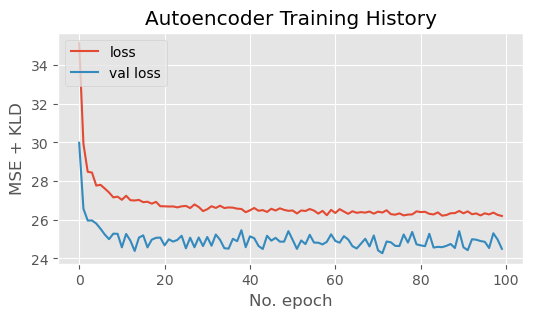

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.8786 - val_loss: 39.9832
Epoch 2/100
283/283 [==============================] - 2s 7ms/step - loss: 29.9199 - val_loss: 37.0819
Epoch 3/100
283/283 [==============================] - 2s 7ms/step - loss: 27.5623 - val_loss: 36.0579
Epoch 4/100
283/283 [==============================] - 2s 6ms/step - loss: 27.0022 - val_loss: 35.8474
Epoch 5/100
283/283 [==============================] - 2s 6ms/step - loss: 26.6980 - val_loss: 35.7176
Epoch 6/100
283/283 [==============================] - 2s 6ms/step - loss: 26.7781 - val_loss: 35.8402
Epoch 7/100
283/283

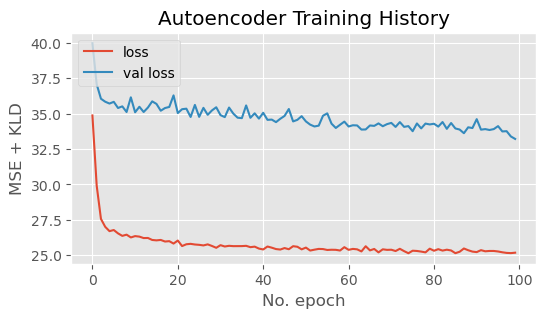

5677/5677 [==============================] - 11s 2ms/step


In [6]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

model = RandomForestClassifier()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)

    # Variational Oversampling 
    vos = VAE_oversampling(hidden_dim= 64,
                            latent_dim=2,
                            original_dim=30,
                            minority_class_id=1,
                            epochs=100,
                            batch_size=1,
                            num_samples_to_generate = num_samples,
                            random_state = 0,
                            optimizer="adam")

    #Fit the VAE oversampling model and get new data set
    X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
    
    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


In [7]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

Accuracy:, 0.999508 (+/- 0.000036)
Precision: 0.944479 (+/- 0.022401)
Recall: 0.761344 (+/- 0.028889)
F1 score: 0.842433 (+/- 0.013811)
ROC_AUC: 0.880632 (+/- 0.014432)


### One fit

Epoch 1/100
6/6 [==============================] - 2s 97ms/step - loss: 37.6193 - val_loss: 33.6589
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 38.0245 - val_loss: 32.6299
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 37.6623 - val_loss: 32.3404
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 36.4754 - val_loss: 31.3818
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 35.3875 - val_loss: 31.2826
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 36.3411 - val_loss: 30.9229
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 34.3757 - val_loss: 29.9237
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 34.7040 - val_loss: 29.2797
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 33.3047 - val_loss: 29.1042
Epoch 10/100
6/6 [==============================] - 0s 16ms/step - loss: 32.8821 - val_loss: 28.7076

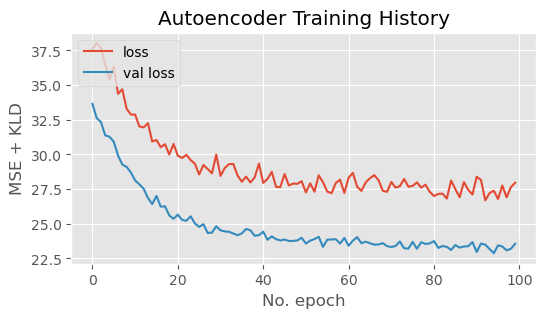

7096/7096 [==============================] - 19s 3ms/step


In [6]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

# Variational Oversampling 
vos = VAE_oversampling(hidden_dim= 64,
                        latent_dim=2,
                        original_dim=30,
                        minority_class_id=1,
                        epochs=100,
                        batch_size=64,
                        num_samples_to_generate = num_samples,
                        random_state = 0,
                        optimizer="adam")

#Fit the VAE oversampling model and get new data set
X_res_val,y_res_val = vos.fit_sample(X_train,y_train)

std = StandardScaler()

X_train_processed = std.fit_transform(X_res_val) 
X_test_processed = std.transform(X_test)

In [7]:
pd.DataFrame(X_res_val)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,161919.000000,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.320000
1,124477.000000,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.990000
2,41191.000000,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.100000
3,132624.000000,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.100000
4,59359.000000,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454897,84292.156250,-4.055493,4.055552,-5.806983,4.830305,-2.611015,-0.626418,-4.641487,1.785115,-1.838143,...,0.412738,2.486640,0.075969,0.461820,0.009684,0.118181,0.126169,0.272411,0.302317,159.052872
454898,83305.148438,-4.679719,7.091312,-7.051935,7.106190,-3.076974,-1.385923,-5.509521,1.691517,-2.586663,...,1.215900,0.669312,0.947242,-0.059132,-0.089591,0.034304,0.074300,0.185232,0.079039,127.421692
454899,85504.250000,-4.614777,3.766243,-7.029948,5.002746,-2.969461,-1.386874,-5.408062,0.605235,-2.586541,...,0.869448,0.631697,0.646060,-0.062256,-0.108916,0.025091,0.050861,0.165792,0.077427,126.287338
454900,98748.117188,-1.382516,3.607324,-3.674462,4.619770,-0.142413,-1.137873,-1.836969,0.655052,-1.615298,...,0.389368,0.729109,0.085116,-0.019608,-0.102635,0.070782,0.064900,0.229080,0.099864,150.811523


In [8]:
randomForest_vae = RandomForestClassifier()

randomForest_vae.fit(X_train_processed, y_res_val)

#predict
pred_lr_vae_val = randomForest_vae.predict(X_test_processed)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9995962220427653
Precision: 0.9518072289156626
Recall: 0.8061224489795918
F1 score: 0.8729281767955801
ROC_AUC: 0.9030260528522045


## Data Augmentation with GAN

### Hyperparameter Tuning

### Cross Validation

In [9]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

model = RandomForestClassifier()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)


    gan = GAN(input_dim= 30, 
                generator_output_dim=30, 
                num_samples=num_samples, 
                epochs=100, 
                batch_size=24)

    #Fit the GAN oversampling model and get new data set
    X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train, y_train)

    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val_gan) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val_gan)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
1/1 [==============================] - 0s 108ms/step
1 [D loss: 0.636278, acc.: 50.00%] [G loss: 0.585172]
1/1 [==============================] - 0s 63ms/step
2 [D loss: 0.635527, acc.: 50.00%] [G loss: 0.581448]
1/1 [==============================] - 0s 62ms/step
3 [D loss: 0.630037, acc.: 50.00%] [G loss: 0.587343]
1/1 [==============================] - 0s 61ms/step
4 [D loss: 0.625911, acc.: 50.00%] [G loss: 0.586708]
1/1 [==============================] - 0s 53ms/step
5 [D loss: 0.627777, acc.: 50.00%] [G loss: 0.602094]
1/1 [==============================] - 0s 54ms/step
6 [D loss: 0.616656, acc.: 50.00%] [G loss: 0.594074]
1/1 [==============================] - 0s 56ms/step
7 [D l

In [ ]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

### One fit

In [6]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

gan = GAN(input_dim= 30, generator_output_dim=30, num_samples=num_samples, epochs=100, batch_size=24)

#Fit the GAN oversampling model and get new data set
X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train, y_train)

std = StandardScaler()

X_train_processed_gan = std.fit_transform(X_res_val_gan) 
X_test_processed_gan = std.transform(X_test)

1/1 [==============================] - 0s 387ms/step
1 [D loss: 0.569694, acc.: 60.42%] [G loss: 0.660127]
1/1 [==============================] - 0s 67ms/step
2 [D loss: 0.568774, acc.: 56.25%] [G loss: 0.655157]
1/1 [==============================] - 0s 58ms/step
3 [D loss: 0.563060, acc.: 58.33%] [G loss: 0.651591]
1/1 [==============================] - 0s 56ms/step
4 [D loss: 0.570556, acc.: 56.25%] [G loss: 0.664129]
1/1 [==============================] - 0s 65ms/step
5 [D loss: 0.561039, acc.: 56.25%] [G loss: 0.669460]
1/1 [==============================] - 0s 62ms/step
6 [D loss: 0.561004, acc.: 56.25%] [G loss: 0.672710]
1/1 [==============================] - 0s 59ms/step
7 [D loss: 0.563488, acc.: 58.33%] [G loss: 0.682309]
1/1 [==============================] - 0s 61ms/step
8 [D loss: 0.553137, acc.: 62.50%] [G loss: 0.675612]
1/1 [==============================] - 0s 96ms/step
9 [D loss: 0.554745, acc.: 60.42%] [G loss: 0.674331]
1/1 [==============================] - 0s 57m

In [7]:
randomForest_vae = RandomForestClassifier()

randomForest_vae.fit(X_train_processed_gan, y_res_val_gan)

#predict
pred_lr_vae_val = randomForest_vae.predict(X_test_processed_gan)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9996137776061234
Precision: 0.9523809523809523
Recall: 0.8163265306122449
F1 score: 0.8791208791208791
ROC_AUC: 0.9081280936685311
